In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv('../../data/train.tsv', sep='\t')
test = pd.read_csv('../../data/test.tsv', sep='\t')
amount = len(train)

train.shape

/home/zhecan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/zhecan/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(156060, 4)

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

v1 = CountVectorizer(stop_words='english', min_df=2, max_df=0.95, max_features=1000)
X1 = v1.fit_transform(train.Phrase)
print X1.shape

(156060, 1000)


In [101]:
from textblob import TextBlob
def extract_verbs_and_adj(phrase):
    words = []
    
    tags = TextBlob(phrase).tags
    for tag in tags:
        if tag[1][:2] == "VB" or tag[1][:2] == "JJ":
            words.append(tag[0])
    return words

phrases_vb_adj = []
for (index, phrase) in enumerate(train.Phrase[:amount]):
    if index % 10 == 0:
        print index
    phrases_vb_adj.append(' '.join(extract_verbs_and_adj(phrase)))
    
print len(phrases_vb_adj)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [108]:
v2 = CountVectorizer(ngram_range=(1, 2),  min_df=2, max_df=0.95, max_features=1000)
X2 = v2.fit_transform(phrases_vb_adj)
print X2.shape

(500, 110)


In [109]:
sentiments = []
for feature in v2.get_feature_names():
    sentiment = TextBlob(feature).sentiment
    value = sentiment.polarity * sentiment.subjectivity
    sentiments.append(value)
    
print v2.get_feature_names()
print sentiments

[u'absolute', u'aggressive', u'aggressive manipulative', u'amuses', u'amuses much', u'are', u'are absolute', u'arts', u'arts proves', u'be', u'be damned', u'be martial', u'be mythic', u'being', u'bilingual', u'cliched', u'cliched perverse', u'damned', u'demonstrating', u'demonstrating is', u'distort', u'distort throw', u'does', u'does leave', u'entertaining', u'entertaining independent', u'epic', u'extravagant', u'extravagant distort', u'good', u'good amuses', u'gorgeous', u'hard', u'hard be', u'hard sitting', u'has', u'has serious', u'hate', u'hate same', u'have', u'have hard', u'high', u'independent', u'inspired', u'introspective', u'introspective entertaining', u'is', u'is be', u'is good', u'is plodding', u'is sweet', u'is worth', u'leave', u'leave much', u'little', u'little recommend', u'manipulative', u'martial', u'martial arts', u'midlife', u'modest', u'modest winning', u'much', u'mythic', u'perverse', u'perverse high', u'plays', u'plodding', u'proves', u'proves sometimes', u'qui

In [110]:
from scipy.sparse import csr_matrix

X3 = csr_matrix(X2.shape)
for index in range(X2.shape[0]):
    row = X2[index]
    for col in range(row.shape[1]):
        X3[index, col] = X2[index, col] * sentiments[col]

In [111]:
from scipy.sparse import hstack
X4 = hstack([X1[:amount], X3])
print X4.shape

(500, 1110)


trial number: 0
trial number: 1
trial number: 2
trial number: 3
trial number: 4
trial number: 5
trial number: 6
trial number: 7
trial number: 8
trial number: 9
trial number: 10
trial number: 11
trial number: 12
trial number: 13
trial number: 14
trial number: 15
trial number: 16
trial number: 17
trial number: 18
trial number: 19


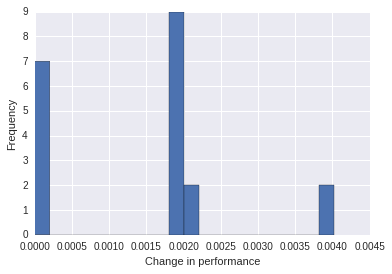

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import sys

def do_trial(X1, X2, y):
    alg = RandomForestClassifier(n_estimators=50, max_depth = 3)
    # change Shuffle to False to see how this affects the conclusions
    cv = cross_validation.StratifiedKFold(y, 3, shuffle=True)
    
    score1 = cross_validation.cross_val_score(alg, X1, y, cv=cv)
    score2 = cross_validation.cross_val_score(alg, X2, y, cv=cv)
    return score1.mean() - score2.mean()

results = []
n_trials = 20
for i in range(n_trials):
    print "trial number: %d" % i
    sys.stdout.flush()
    results.append(do_trial(X4, X3, train.Sentiment[:amount]))
    
plt.hist(results, bins=20)
plt.xlabel('Change in performance')
plt.ylabel('Frequency')
plt.show()